In [1]:
import matplotlib.pyplot as plt
import matplotlib.image
import rasterio
import rasterio.plot
import rasterio.merge
import rasterio.mask
import geopandas as gpd
import cartopy.crs as ccrs
import numpy as np
import warnings
import time
import pandas as pd

In [2]:
import functions

### Start  again by loading in all the gauge data
Note: this is the output from the last cell in the "Slope steepness from DEM" notebook <br>
Make sure to remove the 3 unfound gauges (filter < 99)

In [3]:
gauges = gpd.read_file("Gauge Data/Gauges-with-raster-id.shp",crs=4326)

In [4]:
gauges.query("raster_id < 99", inplace=True)
gauges

,src_id,station_na,station_fi,historic_c,station_la,station_lo,station_el,first_year,last_year,raster_id,geometry
0,00003,FAIR ISLE,fair-isle,shetland,59.526,-1.630,57,1974,2020,4,POINT (-1.63000 59.52600)
3,00023,KIRKWALL,kirkwall,orkney,58.953,-2.901,26,1957,2020,4,POINT (-2.90100 58.95300)
4,00032,WICK AIRPORT,wick-airport,caithness,58.454,-3.090,36,1930,2020,4,POINT (-3.09000 58.45400)
5,00040,CASSLEY,cassley,sutherland,58.168,-4.727,99,1999,2020,4,POINT (-4.72700 58.16800)
6,00044,ALTNAHARRA NO 2,altnaharra-no-2,sutherland,58.288,-4.442,81,1993,2020,4,POINT (-4.44200 58.28800)
...,...,...,...,...,...,...,...,...,...,...,...
363,24218,HARTPURY COLLEGE,hartpury-college,gloucestershire,51.904,-2.312,41,1998,2020,1,POINT (-2.31200 51.90400)
364,24219,MANNINGTON HALL,mannington-hall,norfolk,52.844,1.179,30,1999,2020,0,POINT (1.17900 52.84400)
365,57118,BUTE: ROTHESAY NO2,bute-rothesay-no2,buteshire,55.825,-5.056,36,2013,2020,5,POINT (-5.05600 55.82500)
366,57233,MARGAM NO 2,margam-no-2,glamorganshire,51.555,-3.721,40,2013,2020,1,POINT (-3.72100 51.55500)


The cropped data is indexed by the filenames first so still need those

In [5]:
filenames = []
with open("Cropped Data/filenames.txt") as fin:
    for line in fin:
        filenames.append(line.strip())
# filenames

In [6]:
UK = filenames[68:69] + filenames[80:83] + filenames[95:97]
print(UK)

['n50e000_dem', 'n50w005_dem', 'n50w010_dem', 'n50w015_dem', 'n55w005_dem', 'n55w010_dem']


#### Up until now  main focus has been on a slope of given length
now, first consider a close by slope e.g. 1 - 5px and then look how long this continues for. 

In [7]:
number_px = 5
instance = functions.Raster_Location_OnSlope(gauges, UK, number_px)

#### This is a given array

In [8]:
print(f'Gauge height: {instance.get_array_given_orientation(0, "ns")[0][30]}, array:')
instance.get_array_given_orientation(0, "ns")[0]

Gauge height: 57, array:


array([-32768,    126,    139,    154,    176,    191,    190,    172,
          156,    151,    143,    134,    124,    120,    112,    101,
           90,     78,     75,     73,     70,     66,     62,     68,
           65,     58,     59,     61,     56,     56,     57,     57,
           53,     49,     41,     35,     44,     49,     38,     25,
           17,     35,     43,     22,      4, -32768, -32768, -32768,
       -32768, -32768, -32768, -32768, -32768, -32768, -32768, -32768,
       -32768, -32768, -32768, -32768, -32768], dtype=int16)

#### ant this is its steepness
here 'n_px=5' is used

In [9]:
instance.slope_steepness(0, "ns")

5.441770333082265

#### we can then look just outside the previous range made used to caculate the steepness
Notice if we increment the stepsize it the arrays increase in size, exluding the previous increment used

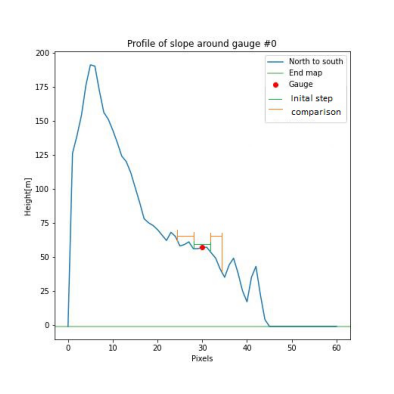

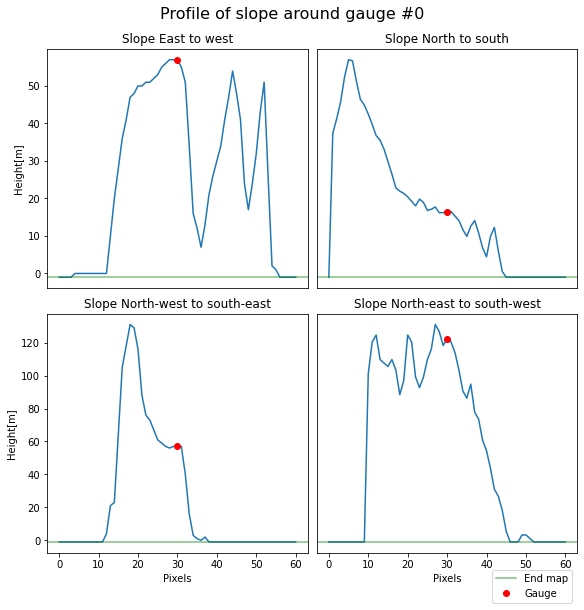

In [10]:
plt.figure(figsize=(7,7))
plt.imshow(matplotlib.image.imread("Figures/Profile of slope around gauge n0ns - showing steps.jpg"))
plt.axis("off");
functions.plotting(gauges, UK, 5).plot_gauge(0, "all")

In [11]:
# gauges

In [12]:
instance.get_array_step(1,"ns",1), instance.get_array_step(0,"ns",2),instance.get_array_step(0,"ns",5)

((array([15, 17], dtype=int16), array([64, 68], dtype=int16)),
 (array([68, 65, 58], dtype=int16), array([35, 44, 49], dtype=int16)),
 (array([70, 66, 62, 68, 65, 58], dtype=int16),
  array([35, 44, 49, 38, 25, 17], dtype=int16)))

In [29]:
instance.change_slope_steepness(0, "nw-se", 6)

(28.959682120403013, -2.129388391206104)